In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, t
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt
import time

FS = 128
root_path = Path.cwd().parent
data_path = root_path / "data" / "raw"

bands = {
    'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13),
    'beta': (13, 30), 'gamma': (30, 45)
}

def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def permutation_entropy(time_series, order=3, delay=1):
    n = len(time_series)
    if n < order * delay: return 0
    permutations = np.array([time_series[i:i + order * delay:delay] for i in range(n - (order - 1) * delay)])
    sorted_idx = np.argsort(permutations, axis=1)
    patterns, counts = np.unique(sorted_idx, axis=0, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-10))

def spike_detection(signal, threshold=3):
    spikes = np.where(np.abs(signal - np.mean(signal)) > threshold * np.std(signal))[0]
    return len(spikes)

def band_features(signal, fs):
    de_sq_list = []
    spike_list = []
    for band_name in bands:
        lowcut, highcut = bands[band_name]
        try:
            filtered = bandpass_filter(signal, fs, lowcut, highcut)
            variance = np.var(filtered)
            if variance <= 0: variance = 1e-10
            de = 0.5 * np.log(2 * np.pi * np.e * variance)
            de_sq_list.append(de ** 2)
            spike_list.append(spike_detection(filtered))
        except:
            de_sq_list.append(0); spike_list.append(0)

    try:
        delta_filtered = bandpass_filter(signal, fs, 0.5, 4)
        pe_delta = permutation_entropy(delta_filtered)
    except: pe_delta = 0

    return de_sq_list + spike_list + [pe_delta]

def process_window(start, eeg_values, window_size_samples, fs):
    window = eeg_values[start:start + window_size_samples]
    if len(window) < window_size_samples: return None
    if np.all(window == 0): return None
    return band_features(window, fs)

def trim_zero_ends(eeg, bis, fs_eeg=128, fs_bis=1):
    bis = np.array(bis)
    eeg = np.array(eeg)
    bis_start_idx = next((i for i, val in enumerate(bis) if val != 0), None)
    bis_end_idx = next((i for i, val in enumerate(bis[::-1]) if val != 0), None)
    if bis_start_idx is None or bis_end_idx is None:
        return np.array([]), np.array([])
    bis_end_idx = len(bis) - bis_end_idx

    start_time = bis_start_idx / fs_bis
    end_time = bis_end_idx / fs_bis
    start_eeg_idx = int(start_time * fs_eeg)
    end_eeg_idx = int(end_time * fs_eeg)

    return eeg[start_eeg_idx:end_eeg_idx], bis[bis_start_idx:bis_end_idx]

def load_patient_data(patient_id, SAMPLE_LIMIT=None):
    print(f"\n--- Loading Patient {patient_id} Data ---")
    window_size_seconds = 56
    step_size_seconds = 1
    advance_seconds = 60

    try:
        df_eeg = pd.read_csv(data_path / f'patient{patient_id}_eeg.csv')
        df_bis = pd.read_csv(data_path / f'patient{patient_id}_bis.csv')
        eeg_raw = df_eeg['EEG'].interpolate('linear').values.flatten()
        bis_raw = df_bis['BIS'].interpolate('linear').values.flatten()
    except Exception as e:
        print(f"Error loading data for Patient {patient_id}: {e}")
        return None, None

    eeg, bis = trim_zero_ends(eeg_raw, bis_raw, fs_eeg=FS, fs_bis=1)

    if len(eeg) == 0:
        print(f"Patient {patient_id}: Data empty after trim.")
        return None, None

    win_samples = int(window_size_seconds * FS)
    step_samples = int(step_size_seconds * FS)
    starts = range(0, len(eeg) - win_samples + 1, step_samples)

    features_raw = Parallel(n_jobs=-1)(
        delayed(process_window)(s, eeg, win_samples, FS)
        for s in starts
    )

    X = np.array([f for f in features_raw if f is not None])

    # Align Target
    advance_steps = int(advance_seconds / step_size_seconds)
    y = bis[advance_steps:]

    min_len = min(len(X), len(y))
    X = X[:min_len]
    y = y[:min_len]

    print(f"   -> Patient {patient_id}: {len(X)} samples available.")

    # Subsampling: Take half of the global limit from this patient
    if SAMPLE_LIMIT:
        limit_per_patient = int(SAMPLE_LIMIT / 2)
        if len(X) > limit_per_patient:
            print(f"   [INFO] Subsampling Patient {patient_id} to {limit_per_patient} samples.")
            indices = np.linspace(0, len(X)-1, limit_per_patient).astype(int)
            X = X[indices]
            y = y[indices]

    return X, y

def experiment(SAMPLE_LIMIT):
    t0_global = time.time()

    X48, y48 = load_patient_data("48", SAMPLE_LIMIT)
    X411, y411 = load_patient_data("411", SAMPLE_LIMIT)

    if X48 is None or X411 is None:
        print("Error: Could not load one or more datasets.")
        return

    print("\n2. Mixing Datasets...")
    X = np.concatenate([X48, X411])
    y = np.concatenate([y48, y411])

    print(f"   -> Total Combined Samples: {len(X)} (P48: {len(X48)}, P411: {len(X411)})")

    print("3. Splitting 80/20 (Random Shuffle)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )

    print(f"   -> Training Set: {len(X_train)} samples")
    print(f"   -> Test Set:     {len(X_test)} samples")

    print("4. Training SVR (Classical RBF)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(kernel='rbf')
    model.fit(X_train_scaled, y_train)

    print("5. Evaluating...")
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)

    n = len(y_pred)
    overall_ci = 1.96 * np.std(y_pred - y_test) / np.sqrt(n)

    print(f"\n--- RESULTS (Mixed 48+411) ---")
    print(f"MSE     : {mse:.5f}")
    print(f"RMSE    : {rmse:.5f}")
    print(f"R2      : {r2:.5f}")
    print(f"R       : {r:.5f}")
    print(f"95% CI  : {overall_ci:.5f}")

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual BIS', alpha=0.7)
    plt.plot(y_pred, label='Predicted BIS (RBF)', linestyle='--')
    plt.legend()
    plt.title(f"Result (Mixed P48 & P411)\nRMSE={rmse:.2f}, R2={r2:.2f}")
    plt.show()


--- Loading Patient 48 Data ---
   -> Patient 48: 8117 samples available.
   [INFO] Subsampling Patient 48 to 100 samples.

--- Loading Patient 411 Data ---
   -> Patient 411: 3799 samples available.
   [INFO] Subsampling Patient 411 to 100 samples.

2. Mixing Datasets...
   -> Total Combined Samples: 200 (P48: 100, P411: 100)
3. Splitting 80/20 (Random Shuffle)...
   -> Training Set: 160 samples
   -> Test Set:     40 samples
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Mixed 48+411) ---
MSE     : 107.98560
RMSE    : 10.39161
R2      : 0.33961
R       : 0.76712
95% CI  : 3.21200


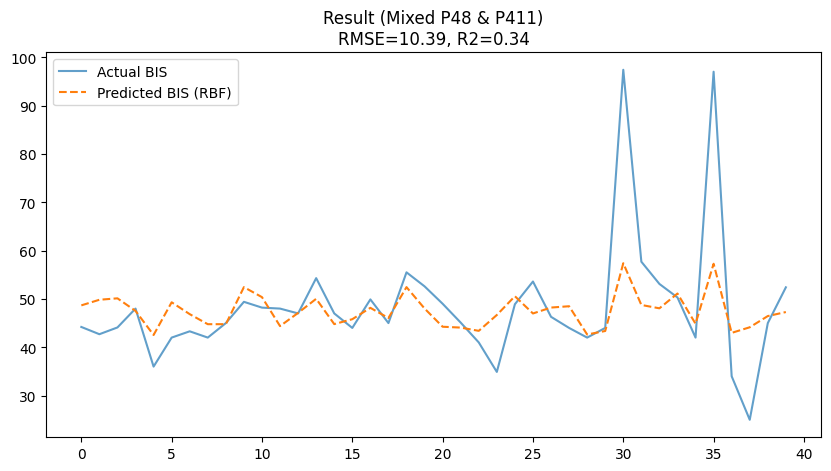

In [4]:
experiment(200)


--- Loading Patient 48 Data ---
   -> Patient 48: 8117 samples available.
   [INFO] Subsampling Patient 48 to 250 samples.

--- Loading Patient 411 Data ---
   -> Patient 411: 3799 samples available.
   [INFO] Subsampling Patient 411 to 250 samples.

2. Mixing Datasets...
   -> Total Combined Samples: 500 (P48: 250, P411: 250)
3. Splitting 80/20 (Random Shuffle)...
   -> Training Set: 400 samples
   -> Test Set:     100 samples
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Mixed 48+411) ---
MSE     : 175.09593
RMSE    : 13.23238
R2      : 0.39611
R       : 0.79309
95% CI  : 2.48713


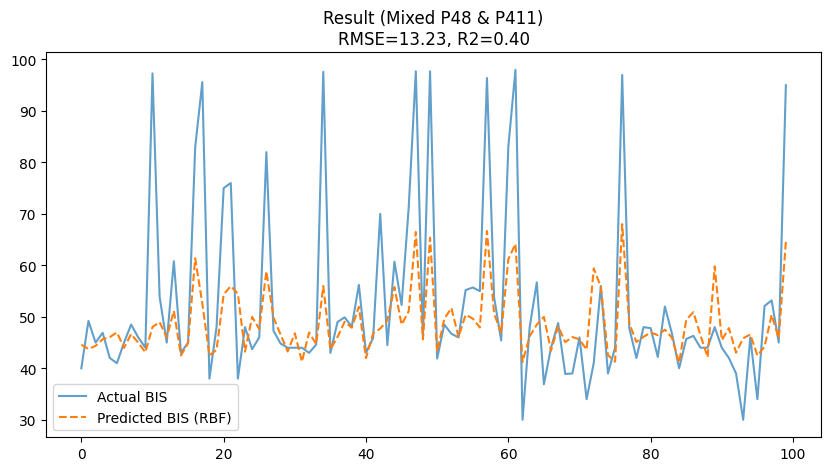

In [5]:
experiment(500)


--- Loading Patient 48 Data ---
   -> Patient 48: 8117 samples available.
   [INFO] Subsampling Patient 48 to 500 samples.

--- Loading Patient 411 Data ---
   -> Patient 411: 3799 samples available.
   [INFO] Subsampling Patient 411 to 500 samples.

2. Mixing Datasets...
   -> Total Combined Samples: 1000 (P48: 500, P411: 500)
3. Splitting 80/20 (Random Shuffle)...
   -> Training Set: 800 samples
   -> Test Set:     200 samples
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Mixed 48+411) ---
MSE     : 114.07463
RMSE    : 10.68057
R2      : 0.63311
R       : 0.84393
95% CI  : 1.46619


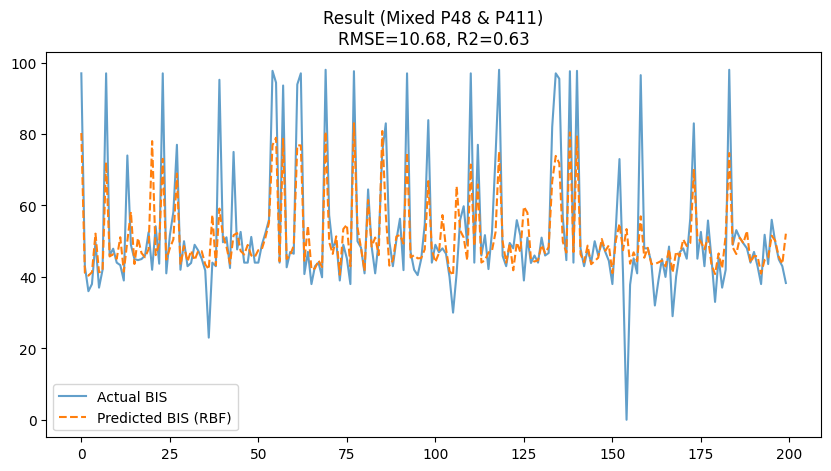

In [6]:
experiment(1000)


--- Loading Patient 48 Data ---
   -> Patient 48: 8117 samples available.
   [INFO] Subsampling Patient 48 to 1000 samples.

--- Loading Patient 411 Data ---
   -> Patient 411: 3799 samples available.
   [INFO] Subsampling Patient 411 to 1000 samples.

2. Mixing Datasets...
   -> Total Combined Samples: 2000 (P48: 1000, P411: 1000)
3. Splitting 80/20 (Random Shuffle)...
   -> Training Set: 1600 samples
   -> Test Set:     400 samples
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Mixed 48+411) ---
MSE     : 45.36028
RMSE    : 6.73500
R2      : 0.83723
R       : 0.91863
95% CI  : 0.65932


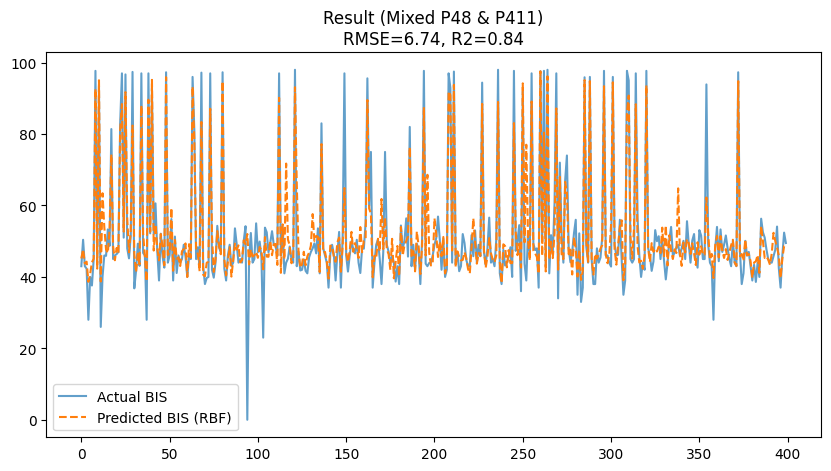

In [7]:
experiment(2000)


--- Loading Patient 48 Data ---
   -> Patient 48: 8117 samples available.
   [INFO] Subsampling Patient 48 to 3000 samples.

--- Loading Patient 411 Data ---
   -> Patient 411: 3799 samples available.
   [INFO] Subsampling Patient 411 to 3000 samples.

2. Mixing Datasets...
   -> Total Combined Samples: 6000 (P48: 3000, P411: 3000)
3. Splitting 80/20 (Random Shuffle)...
   -> Training Set: 4800 samples
   -> Test Set:     1200 samples
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Mixed 48+411) ---
MSE     : 46.10305
RMSE    : 6.78992
R2      : 0.85847
R       : 0.92819
95% CI  : 0.38332


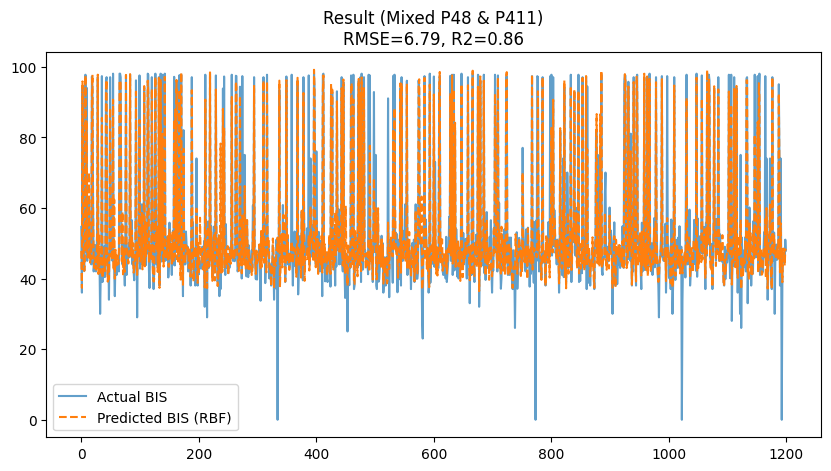

In [8]:
experiment(6000)